# Sentiment Analysis of Macklemore & Ryan Lewis's "The Heist"

### [Anthony Xiang](http://www.github.com/anthonyxiang1)

The Heist is one of my first and favorite hip hop albums that I've listened to; at the time I was 14 years old - young, innocent, and sheltered. The Heist has so much topical diversity and a huge range of clever wordplay in conjunction with the amazing production by Ryan Lewis. It's opened my eyes to the problems outside of my life and my bubble in Long Island. For example, "Wing$" and "A Wake" provide social commentary on the issues of American culture as a whole. Songs like "Thin Line", "Neon Cathedral", and "Starting Over" introduced to me through solemn storytelling struggle and pain that I've, fortunately, never had to face. Other songs on the album are uplifting - they pushed me to be grateful for what I have; they teach me to be confident in my ability; they inspire me to fully dedicated myself to my dreams.

The aim of this project is to take a closer look at the range of emotions in this album using sentiment analysis. Sentiment analysis processes chunks of text using precreated dictionaries to categorize lyrics by emotional intent. For example, it can extract positive or negative sentiment from a sentence, or it can determine if a phrase is sad, angry, or confused. The goal is to see if the sentiment analysis labels agree or disagree with the song's meaning and intent.

Of course, a huge part of a song's tone comes from what we hear - the production, the volume, the instruments, the voice tone, among many other factors. I hope that analyzing only the lyrics will still accurately capture the sentiment of each song on the album. Let's get started!



## Table of Contents <a name="top"></a>
1. [The Breakdown](#introduction)
2. [Data Cleaning + Exploration](#paragraph1)
    1. [Wordcloud 1](#subparagraph21)
3. [Lemmatization](#paragraph2)
    1. [Wordcloud Lemmatized](#subparagraph3-1)
    2. [Getting Album Word Counts](#subparagraph3-2)
    3. [Song Word Counts](#subparagraph3-3)
4. [Word-Emotion Association Lexicon](#paragraph4)
    1. [VADER Predictions](#subparagraph4-1)
    2. [VADER Results](#subparagraph4-2)
5. [NRC Analysis](#paragraph5)
    1. [NRC Predictions](#subparagraph5-1)
    2. [NRC Results](#subparagraph5-2)
6. [Track Sentiments](#paragraph6)
7. [Album Sentiment](#paragraph7)
8. [Conclusion](#paragraph8)

## The Breakdown:  <a name="introduction"></a>
[Back to top](#top)


<strong>Artists</strong> has <strong> Albums</strong>  has <strong> Tracks</strong>  has <strong> Lyrics</strong>

I'm looking for libraries that will allow me to connect one layer to its adjacent sublayer (eg. get tracks from an album).

### Some song fetching libraries

<strong>Lyricsgenius</strong> - gets tracks from artists, lyrics from tracks

<strong>Spotipy</strong> - gets tracks from albums

<strong>PyLyrics</strong> - gets albums from artists, lyrics from tracks

<strong>Note:</strong> PyLyrics has an error for getting tracks from albums - a bug in the library

I will use Spotipy and PyLyrics together, which will allow us to access all the data we need.

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from PyLyrics import *
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import contractions
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
import spacy
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
from operator import add

In [2]:
# private credentials
cid = "4d877a6a6ac2432198263ed459537555" 
secret = "9a32644a0ad840a288d1580cf2c5d499" 
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 
sp.trace=False 

# find album by name
albumName = "The Heist Deluxe"
results = sp.search(q = "album:" + albumName, type = "album")

# get the first album uri
album_id = results['albums']['items'][0]['uri']

One of the songs on the album, called BomBom, is a beautiful, fully instrumental piece to showcase the talent and genius of Ryan Lewis's productions. Because there are no lyrics, it will give an error when we try to fetch it in PyLyrics. We remove it from the tracklist for this reason.

In [3]:
# get album tracks
tracklist = []
tracks = sp.album_tracks(album_id)
for track in tracks['items']:
    tracklist.append(track['name'])

tracklist.remove('BomBom (feat. The Teaching)')

tracklist

['Ten Thousand Hours',
 "Can't Hold Us (feat. Ray Dalton)",
 'Thrift Shop (feat. Wanz)',
 'Thin Line (feat. Buffalo Madonna)',
 'Same Love (feat. Mary Lambert)',
 'Make The Money',
 'Neon Cathedral (feat. Allen Stone)',
 'White Walls (feat. ScHoolboy Q, Hollis)',
 'Jimmy Iovine (feat. Ab-Soul)',
 'Wing$',
 'A Wake (feat. Evan Roman)',
 'Gold (feat. Eighty4 Fly)',
 'Starting Over (feat. Ben Bridwell)',
 'Cowboy Boots',
 'Castle',
 'My Oh My',
 'Victory Lap']

In [4]:
# create a key value pair for each tracks as - trackName : lyrics. Convert all characters to lowercase.
d = {}

singer="Macklemore & Ryan Lewis"

for track in tracklist:
    d[track] = PyLyrics.getLyrics(singer, track).lower()

c:\users\antho\appdata\local\programs\python\python37\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file c:\users\antho\appdata\local\programs\python\python37\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


## Data Cleaning + Exploration <a name="paragraph1"></a>
[Back to top](#top)

Looking at the lyrics for each song, there are two that include the singer's name for that segment of the song. We will get rid of that as it it is not part of the song itself.

In [5]:
d['Same Love (feat. Mary Lambert)'] = d['Same Love (feat. Mary Lambert)'].replace("macklemore:", "")
d['Same Love (feat. Mary Lambert)'] = d['Same Love (feat. Mary Lambert)'].replace("mary lambert:", "")

d['White Walls (feat. ScHoolboy Q, Hollis)'] = d['White Walls (feat. ScHoolboy Q, Hollis)'].replace("macklemore", "")
d['White Walls (feat. ScHoolboy Q, Hollis)'] = d['White Walls (feat. ScHoolboy Q, Hollis)'].replace("hollis", "")
d['White Walls (feat. ScHoolboy Q, Hollis)'] = d['White Walls (feat. ScHoolboy Q, Hollis)'].replace("schoolboy q", "")

In [6]:
# create a string with all of the lyrics in the album
all = ""

for track in tracklist:
    all += PyLyrics.getLyrics(singer, track)

<a name="subparagraph21"></a>

Looking at a wordcloud for all the lyrics on the album, there are very wholesome and positive words here! Macklemore sticks to a central theme in his happy upbeat songs ("Gold", "Same Love") and repeats those words throughout but uses more metaphors and storytelling and, in a way, dances around saying negative words in negative topics of drug addiction, relationships, music industry, and consumerism. This contrast is reflected in the larger frequency of happy words in the album overall.

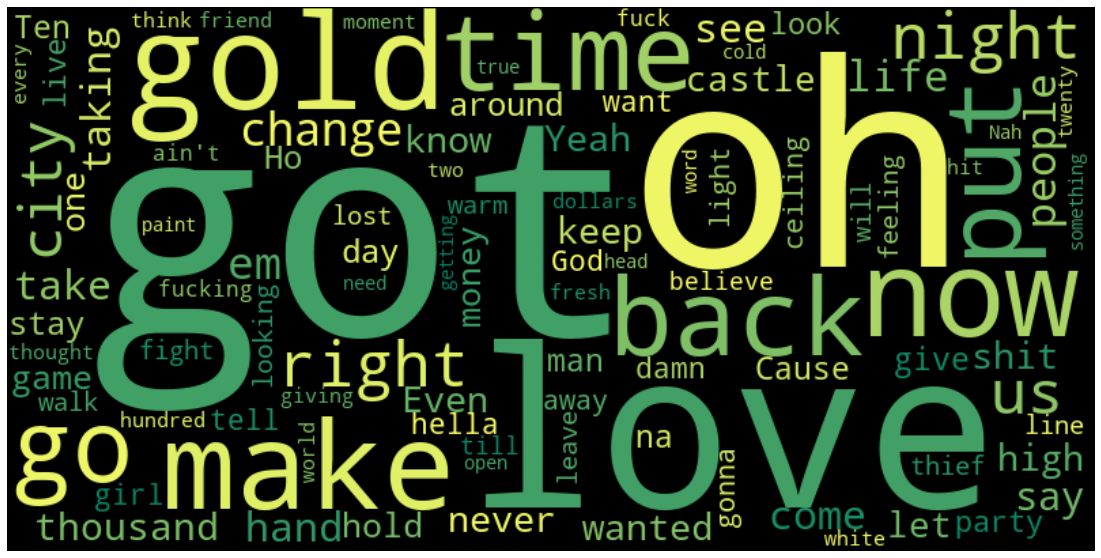

In [7]:
# create and generate a word cloud image
wordcloud = WordCloud(max_words=100, width=800, height=400, colormap="summer",
                          collocations = False, background_color="black").generate(all)

# display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
# makes a dataframe of track names and corresponding lyrics
df = pd.DataFrame({'Track':list(d.keys()), 'Lyrics':list(d.values())} )

df.head()

,Track,Lyrics
0,Ten Thousand Hours,uh\ni hope that god decides to talk through hi...
1,Can't Hold Us (feat. Ray Dalton),"alright, okay\nalright, okay\nalright, okay\n\..."
2,Thrift Shop (feat. Wanz),"hey, macklemore, can we go thrift shopping?\n\..."
3,Thin Line (feat. Buffalo Madonna),and on on and on and on we go\nand on on and o...
4,Same Love (feat. Mary Lambert),\nwhen i was in the third grade\ni thought tha...


### Some edits to be made to the lyrics - undo the contractions, and then lemmatize each word to its base.

We will get rid of the line breaks, expand the contractions, remove special characters, remove single characters (they don't contribute much to sentiment), and clean up the spacing so that the text is consistent.

In [9]:
# get rid of empty lines
for index, row in df.iterrows():
    row['Lyrics'] = row['Lyrics'].replace("\n", " ")

In [10]:
# new column that expands contractions of lyrics
df['LyricsExpand'] = df.apply(lambda row: contractions.fix(row['Lyrics']), axis=1)

# new column that removes special characters
df['LyricsNoSpecial'] = df.apply(lambda row: re.sub(r'\W', ' ', row['LyricsExpand']), axis=1)

# new column that removes single letters and makes consistent spacing
df['LyricsReady'] = df.apply(lambda row: re.sub(r'\s+[a-zA-Z]\s+', ' ', row['LyricsNoSpecial']), axis=1)
df['LyricsReady'] = df.apply(lambda row: re.sub(r'\s+', ' ', row['LyricsReady'], flags=re.I), axis=1)

## Lemmatization <a name="paragraph2"></a>
[Back to top](#top)

Now that we have all the words of the album in a clean format, we will start to set up for sentiment analysis. The first step is to reduce all morphological variations of a word into a base, root word.

In natural language processing this can be done using <strong>stemming</strong> or <strong>lemmatization</strong>. Stemming  creates forms with no prefix or suffix attached: <strong>studies becomes studi</strong>. Often it creates bases that are not words in the dictionary. Lemmatization, on the other hand, implements an algorithm that references a dictionary to return real words: <strong>studies becomes study</strong>. Lemmatization is better for us to use in this case as we need the complete base words to feed into our sentiment analysis library.

In [11]:
# load the lemmatizing dictionary
sp = spacy.load('en_core_web_sm')

# Instantiate a list to keep the lemmatized lyrics
lyrics_lemma = []

for index, row in df.iterrows():
    song1str = ""
    song = sp(row['LyricsReady'])
    
    for word in song:
        if (word.lemma_ == '-PRON-'):        # spacy converts pronouns to "-PRON-", we will keep the pronouns in
            song1str += word.lower_ + " "
        else:
            song1str += word.lemma_ + " "
    
    lyrics_lemma.append(song1str)
    
df['LyricsLemma'] = lyrics_lemma  # create a new column for lemmatized lyrics

# clean single characters
df['LyricsLemma'] = df.apply(lambda row: re.sub(r'\s+[a-zA-Z]\s+', ' ', row['LyricsLemma']), axis=1)

<a name="subparagraph3-1"></a>

The new word cloud is a bit different from the old one. The word 'got' became 'get' after we lemmatized and is then removed from the wordcloud because 'get' is a stopword (like 'a', 'the', etc.). One big change is the increase in the frequency of the word 'will', which probably came from expanding all those contractions like I'll and we'll.

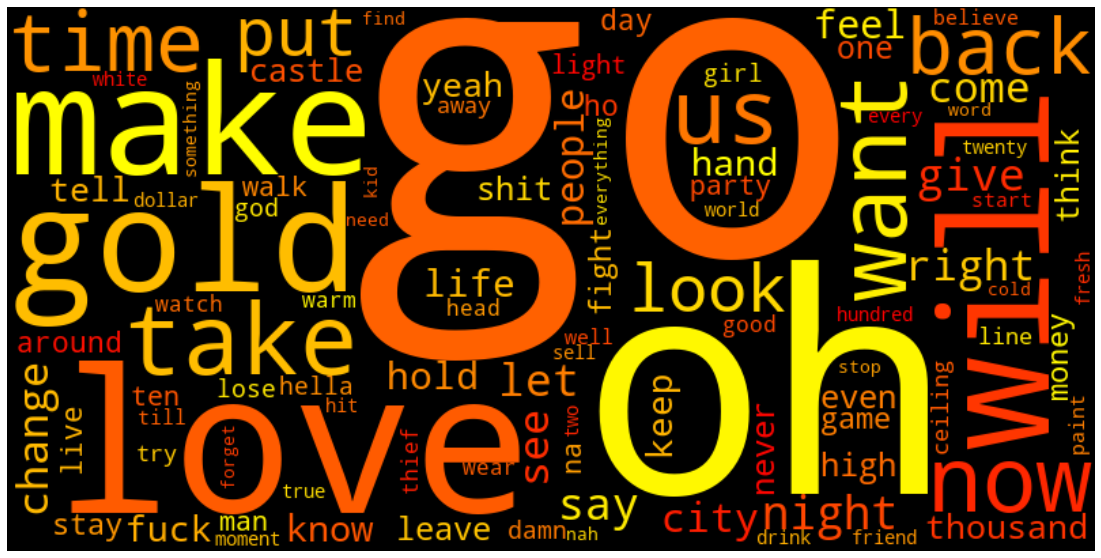

In [12]:
# another word cloud
all_ready = ""  

for index, row in df.iterrows():
    all_ready += row['LyricsLemma']

wordcloud = WordCloud(max_words=100, width=800, height=400, colormap="autumn",
                          collocations = False, background_color="black").generate(all_ready)

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Getting Album Word Counts <a name="subparagraph3-2"></a>

Counting the unique values with re.findall() or count() functions are also counting substrings, which will overcount what we want. We use a regular expression to include the boundaries between the words we want, which filters out substrings - the \\b essentially means "whole words only". We also set aside the common words in the list: we set the stop words equal to 0 just so we have them in the unique words list, but not interfering with the frequencies.

In [13]:
def countUnique(str):
    df_freq = pd.DataFrame({'words': pd.unique(str.split())})
    counts = []
    stop_words = set(stopwords.words('english'))
    
    for index, row in df_freq.iterrows():
        if (row['words'] in stop_words):
            counts.append(0)
        else:
            counts.append(len(re.findall('\\b'+row['words']+'\\b', str)))

    df_freq['Count'] = counts
    
    return df_freq

word_count = countUnique(all_ready).sort_values(by='Count', ascending=False)

word_count.head(5)

,words,Count
48,get,124
47,like,92
225,go,67
360,oh,54
139,love,51


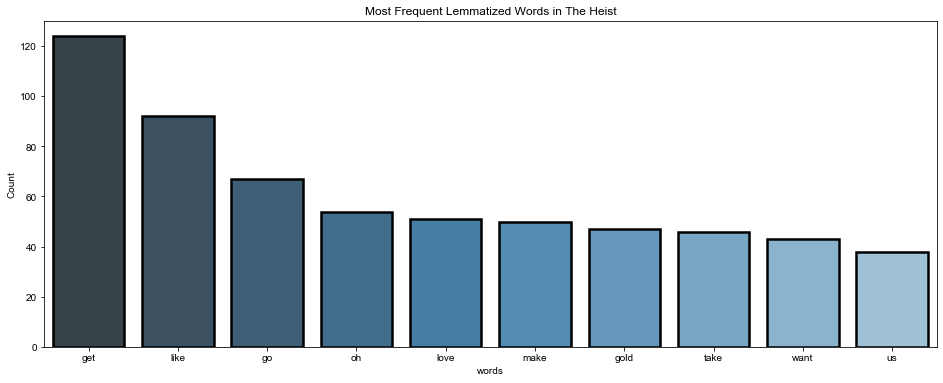

In [14]:
plt.figure(figsize=(16,6))
plt.title("Most Frequent Lemmatized Words in The Heist")
plt.xlabel('Words')
plt.ylabel('Frequency')
sns.set(style="darkgrid")
sns.barplot(x = 'words', y='Count', data=word_count[0:10], palette="Blues_d", linewidth=2.5, edgecolor="0")

### Song Word Counts - Same Love  <a name="subparagraph3-3"></a>

We can do the same with each song on the album. Same Love is a song that talks about gay rights and calls for pro-gay marriage. The lyrics are incredibly wholesome, and equally heartwarming is the music video. The song has frequent mentions of love, being warm and kind to others, changing for the better, and that "love is patient".

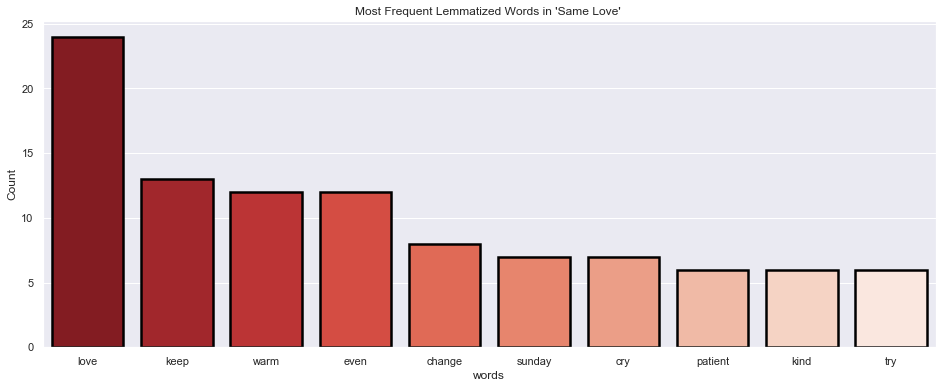

In [15]:
samelove_count = countUnique(df['LyricsLemma'][4]).sort_values(by='Count', ascending=False)

plt.figure(figsize=(16,6))
plt.title("Most Frequent Lemmatized Words in 'Same Love' ")
plt.xlabel('Words')
plt.ylabel('Frequency')
sns.set(style="darkgrid")
sns.barplot(x = 'words', y='Count', data=samelove_count[0:10], 
            palette=sns.color_palette("Reds_r", 10), linewidth=2.5, edgecolor="0")

### Jimmy Iovine

This track tells the story of Macklemore meeting Jimmy Iovine, a major record label owner, for negotiation of a record deal. From the beginning of the song, the listener feels rushed by the upbeat instrumental and tension in the journey up to the office. Notice how many of these top frequency words are verbs, actions used to tell a captivating story and ultimately the disgust in how unfair record label deals are to up and coming artists.

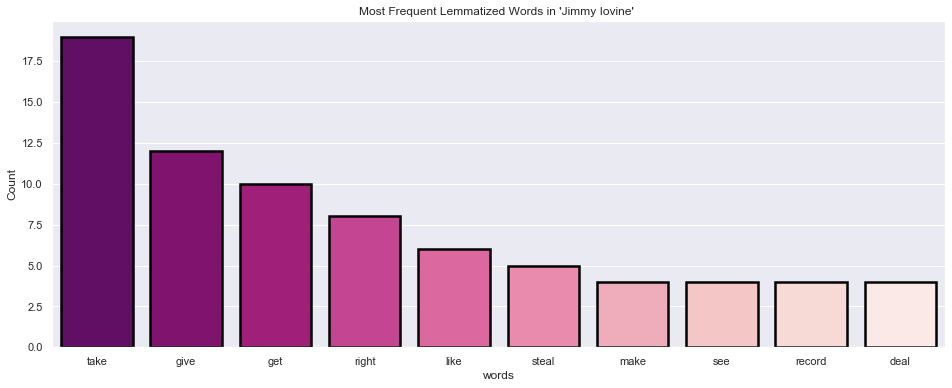

In [16]:
samelove_count = countUnique(df['LyricsLemma'][8]).sort_values(by='Count', ascending=False)

plt.figure(figsize=(16,6))
plt.title("Most Frequent Lemmatized Words in 'Jimmy Iovine' ")
plt.xlabel('Words')
plt.ylabel('Frequency')
sns.set(style="darkgrid")
sns.barplot(x = 'words', y='Count', data=samelove_count[0:10], 
            palette=sns.color_palette("RdPu_r", 10), linewidth=2.5, edgecolor="0")

## The Fun Stuff - Applying Word-Emotion Association Lexicon to our Lyrics <a name="paragraph4"></a>
[Back to top](#top)

### Some sentiment analysis libraries in Python

<strong>VADER</strong> - positive, neutral, negative, and compound sentiments of a word/sentence, handles emojis, slang, and punctuation as well.

<strong>nltk</strong> - positive and negative sentiments of a word/sentence, seems strong for ML and classifier training use cases.

<strong>textblob</strong> - polarity and subjectivity of a phrase, part of speech tagging, much more.

We use VADER to get the positive and negative sentiments of each song. We use the original lyrics stored in our dictionary (because we need some form of phrases/sentences), run it line by line, getting negative and positive sentiment of each line, and add it all up for each song. The difference of those scores will be our metric for determining a positive song vs. a negative song. It is stored in the dataframe and graphed.

### VADER Predictions:  <a name="subparagraph4-1"></a>

most positive - same love or gold

most negative - jimmy iovine, starting over

In [17]:
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores():
    
    # lists to store values of each song's sentiments
    neglist = []
    poslist = []
    compoundlist = []
        
    for index, row in df.iterrows(): # for each lyrics
        # counters for each line's sentiments
        neg = 0
        pos = 0
        compound = 0

        for line in d[row['Track']].split('\n'): # for each line
            score = analyser.polarity_scores(line)
            neg += score['neg']
            pos += score['pos']
            compound += score['compound']

        neglist.append(neg)
        poslist.append(pos)
        compoundlist.append(compound)
    
    df['neg'] = neglist
    df['pos'] = poslist
    df['compound'] = compoundlist

    return df
    
sentiment_analyzer_scores().head()

,Track,Lyrics,LyricsExpand,LyricsNoSpecial,LyricsReady,LyricsLemma,neg,pos,compound
0,Ten Thousand Hours,uh i hope that god decides to talk through him...,uh i hope that god decides to talk through him...,uh i hope that god decides to talk through him...,uh hope that god decides to talk through him t...,uh hope that god decide to talk through him th...,6.213,7.987,2.0531
1,Can't Hold Us (feat. Ray Dalton),"alright, okay alright, okay alright, okay ret...","alright, okay alright, okay alright, okay ret...",alright okay alright okay alright okay ret...,alright okay alright okay alright okay return ...,alright okay alright okay alright okay return ...,3.354,11.019,7.7732
2,Thrift Shop (feat. Wanz),"hey, macklemore, can we go thrift shopping? w...","hey, macklemore, can we go thrift shopping? w...",hey macklemore can we go thrift shopping w...,hey macklemore can we go thrift shopping what ...,hey macklemore can we go thrift shop what what...,6.447,6.547,-1.4845
3,Thin Line (feat. Buffalo Madonna),and on on and on and on we go and on on and on...,and on on and on and on we go and on on and on...,and on on and on and on we go and on on and on...,and on on and on and on we go and on on and on...,and on on and on and on we go and on on and on...,5.355,14.554,10.1080
4,Same Love (feat. Mary Lambert),when i was in the third grade i thought that ...,when i was in the third grade i thought that ...,when i was in the third grade i thought that ...,when was in the third grade thought that was ...,when be in the third grade think that be gay...,8.745,19.328,9.7086


### VADER Results <a name="subparagraph4-2"></a>

The results align pretty well with our predictions! We see that negative outweigh the positive sentiments in four songs: Neon Cathedral, Jimmy Iovine, A Wake, and Starting Over. This actually very accurately captures the emotions of these songs. These are the more introspective, dark, and conscious tracks on the album. Neon Cathedral and Starting Over are both about Macklemore's troubles as an alcoholic. Jimmy Iovine is a song about a major record label that tried to rip him off. A Wake is about his waking up to see the problems of America and America's youth generation.

Futhermore, we see that the most positive tracks are Same Love, Gold, and Can't Hold Us. These are songs about acceptance, equality, and having fun.

This SA wasn't perfect: Thin Line is a very emotional track about his relationship problems that I expected to be more negative than positive, but this was not the case (in my interpretation). Thin Line showed to be one of the most positive songs on the album as well, which is surprising. Looking into the lyrics, the song says 'love' a lot, but in a negative context. This is confirmed by one of the repeated lines - "each time I love her less" - which has a negative score of 0, but a positive score of 0.512. Other negative lines of the song give none to low scores for negative sentiment as well. Thus the sentiment analysis algorithm is not perfectly accurate.

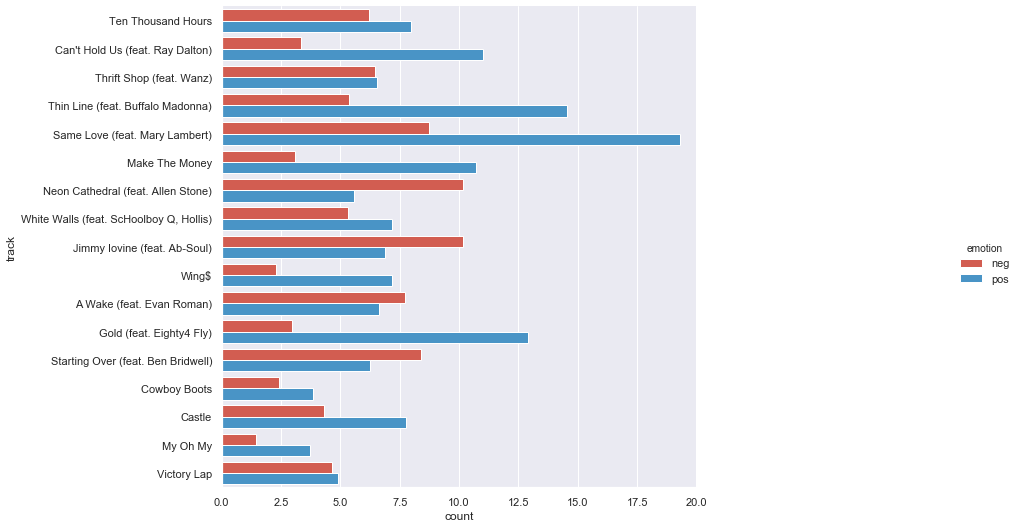

In [18]:
df_sentiment = pd.melt(df, id_vars=['Track'], var_name="emotion", value_vars=['neg', 'pos'])

g = sns.catplot(x="value", y="Track", hue="emotion", 
            data=df_sentiment, palette=["#e74c3c", "#3498db"], kind="bar")
g.fig.set_size_inches(30,8)
g.set_axis_labels('count', 'track')
g.set(xlim=(0, 20))

## Use R for NRC Analysis <a name="paragraph5"></a>
[Back to top](#top)

NRC is a emotion lexicon that characterizes words to certain emotions, such as anger and confused. 

nrc is an emotion lexicon that provides us with more detailed sentiments than just positive or negative or neutral. Nrc associates words with emotion categories such as fear, joy, anger, disgust, surprise, and many more. 

Unfortunately, there is no Python library that integrates nrc easily. There is a library in R that does this - <strong>tidytext</strong> - which is very easy to use. Put the line <strong>
get_sentiments("nrc")</strong> and you have a dataframe of words with their many associated sentiments, one for each line. 

We could have R assign sentiments for each word, or go one step further to assign for each song. Since we want python to do most of the heavy lifting, we will get sentiments for each word and go from word to song sentiment in here. We will export the unique word dataframe to R, then R will read it and make changes. R will export the nrc table and we read that back into Python.

Notice, df_sentiment has only words with some sentiment to them, so words like 'get' and 'oh' are removed.

In [19]:
word_count.to_excel(r'C:\Users\antho\OneDrive\Documents\theheist.xlsx', index = None, header=True)

### R code manipulates the xlsx file above, and writes the xlsx file below

df_sentiment = pd.read_excel(r'C:\Users\antho\OneDrive\Documents\finalone.xlsx')

df_sentiment = df_sentiment.fillna(0).sort_values(by='count', ascending=False)

df_sentiment = df_sentiment.drop(['Unnamed: 0','count'], axis=1)

df_sentiment.head()

,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
248,love,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
170,gold,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
424,time,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,change,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
357,shit,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### NRC Predictions: <a name="subparagraph5-1"></a>

Anger: maybe jimmy iovine

Anticipation: jimmy iovine

Disgust: starting over

Fear - starting over

Joy - gold, cant hold us

Negative- a wake

Positive - same love, my oh my, or victory lap

Sadness - neon cathedral or starting over

Doing this with a double for loop is pretty inefficient. I will try to do this with a dictionary of lists (for sentiments) instead of looping in the dataframe.

In [20]:
dict_sentiment = df_sentiment.set_index('word').T.to_dict('list')

dict_sentiment['love']

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]

In [21]:
# gets sentiments of a song: returns a list
def songSentiment(str):
    song_sent = [0,0,0,0,0,0,0,0,0,0]
    
    for word in str.split(' '):  # for each word in that song 
        if (word in dict_sentiment):
            song_sent = list( map(add, song_sent, dict_sentiment[word]) )
                
    return song_sent

# runs songSentiment to each song in the album: returns a list of lists
def eachSongSentiment():
    all_song_sent = [[0,0,0,0,0,0,0,0,0,0]]

    for i in range(len(df)):    
        all_song_sent.append(songSentiment(df['LyricsLemma'][i]))
        
    return (all_song_sent)


allsong_df = pd.DataFrame(eachSongSentiment(),columns=df_sentiment.columns[1:])
allsong_df = allsong_df.drop([0]).reset_index()
allsong_df = allsong_df.drop(['index'], axis=1)
allsong_df['Track'] = df['Track']


# INEFFICIENT WAY TWO FOR LOOPS - FOR LOOP LYRICS AND FOR LOOP TABLE OF WORDS W SENTIMENT
# def songSentiment(str):
#     anger = 0
#     anti = 0
#     disgust = 0
#     fear = 0
#     joy = 0
#     sad = 0
#     surprise = 0
#     trust = 0

#     for word in str.split(' '):  # for each word in that song 
#         for index, row in df_sentiment.iterrows(): # for each word in the sentiment df
#             if (word == row['word']):
#                 anger += row['anger']
#                 anti += row['anticipation']
#                 disgust += row['disgust']
#                 fear += row['fear']
#                 joy += row['joy']
#                 sad += row['sadness']
#                 surprise += row['surprise']
#                 trust += row['trust']   

#     print([anger, anti, disgust, fear, joy, sad, surprise, trust])

### NRC Results: <a name="subparagraph5-2"></a>

Anger: The angriest song is Neon Cathedral. Jimmy Iovine is second angriest.

Anticipation: The song with most anticipation is a tie between Neon Cathedral and Jimmy Iovine.

Disgust: I would say that Starting Over is the song with most disgust. The song is about Macklemore's struggle with addiction and relapse; there is definitely disgust with himself. This is not reflected in the analysis results.

Fear: Surprisingly Same Love shows a lot of fear. Aside from that the results are fairly accurate.

Positive - Gold has the most, then Same Love

Sadness - Neon Cathedral and then Starting Over

Surprisingly Ten Thousand Hours, Can't Hold Us, and Thrift Shop are more negative than positive. Our predictions for anger, anticipation, fear, and sadness are accurate. NRC tells us more detailed information about specific emotions of the track, but the NRC scores appears to have more flaws in the track's sentiment than textblob's positive/negative scores did.

In [22]:
allsong_df

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Track
0,15.0,19.0,10.0,13.0,16.0,30.0,29.0,16.0,11.0,15.0,Ten Thousand Hours
1,15.0,10.0,6.0,13.0,7.0,26.0,18.0,8.0,1.0,12.0,Can't Hold Us (feat. Ray Dalton)
2,17.0,5.0,18.0,5.0,5.0,35.0,20.0,6.0,9.0,16.0,Thrift Shop (feat. Wanz)
3,8.0,18.0,6.0,17.0,30.0,30.0,48.0,16.0,11.0,21.0,Thin Line (feat. Buffalo Madonna)
4,14.0,19.0,10.0,28.0,42.0,33.0,59.0,19.0,4.0,24.0,Same Love (feat. Mary Lambert)
5,19.0,24.0,4.0,21.0,30.0,16.0,53.0,5.0,21.0,35.0,Make The Money
6,32.0,27.0,26.0,38.0,22.0,66.0,43.0,33.0,23.0,38.0,Neon Cathedral (feat. Allen Stone)
7,16.0,14.0,11.0,9.0,8.0,29.0,21.0,12.0,7.0,12.0,"White Walls (feat. ScHoolboy Q, Hollis)"
8,24.0,27.0,13.0,20.0,17.0,31.0,29.0,22.0,18.0,18.0,Jimmy Iovine (feat. Ab-Soul)
9,14.0,10.0,6.0,12.0,11.0,24.0,24.0,9.0,12.0,20.0,Wing$


In [23]:
# melt variables for graphing - row for each sentiment of each song
allsong_graph = pd.melt(allsong_df, id_vars=['Track'], value_vars=allsong_df.columns[0:10])

## Track Sentiments <a name="paragraph6"></a>
[Back to top](#top)

Here you can visualize the table above. The colors are selected as colors that represent that sentiment (red for angry, etc.).

In [24]:
def plotSentiment(song):
    plt.figure(figsize=(16,6))
    plt.title(song)

    sns.set(style="darkgrid")
    sns.barplot(x = 'variable', y='value', 
                data=allsong_graph[allsong_graph['Track'] == song], 
                palette=["#ff3030", "#fbfd1c","#8c9535", "#700d64", 
                     "#ffad30", "#8c928b", "#F0EAD6", "#334660", "#98fb98", "#00bfff"],
                linewidth=2.5, edgecolor="0")
    plt.xlabel('Sentiment')
    plt.ylabel('Count')

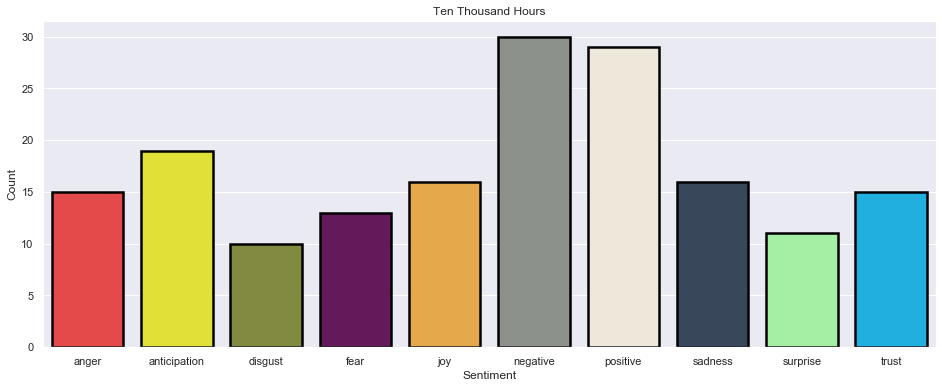

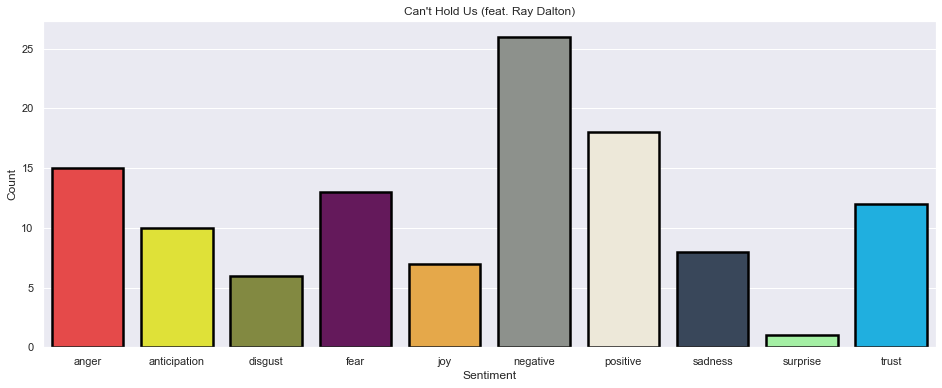

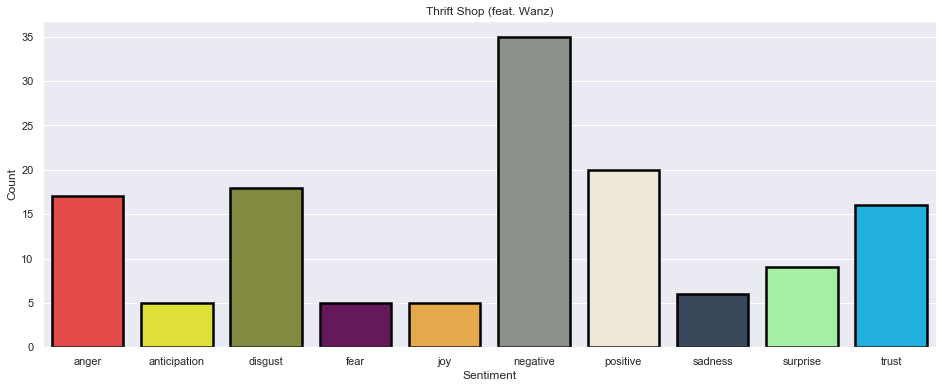

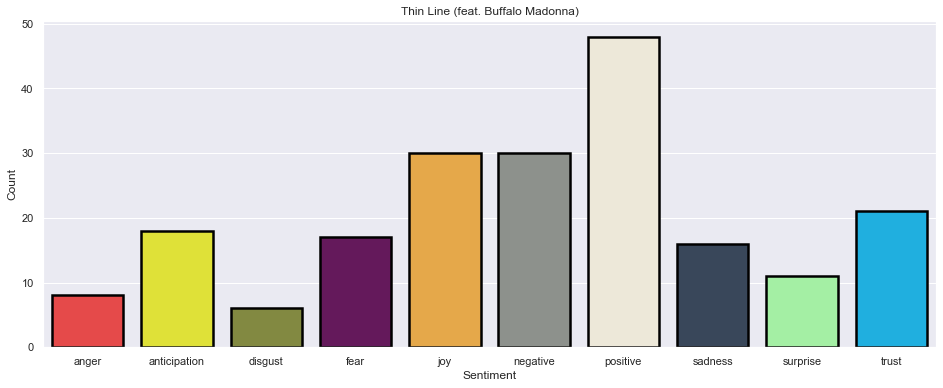

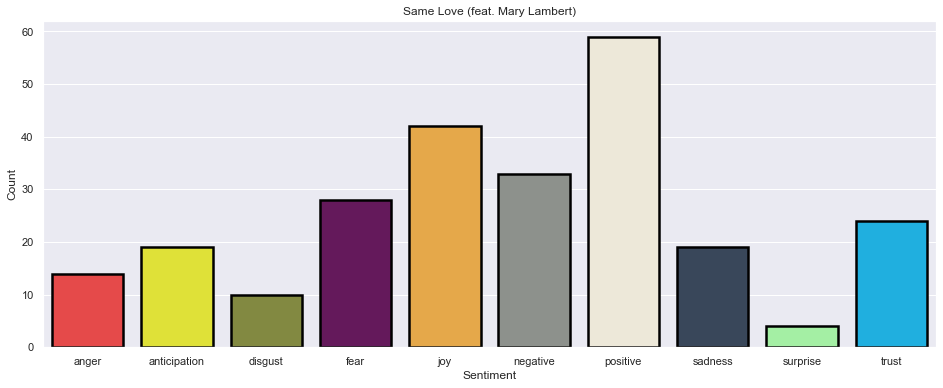

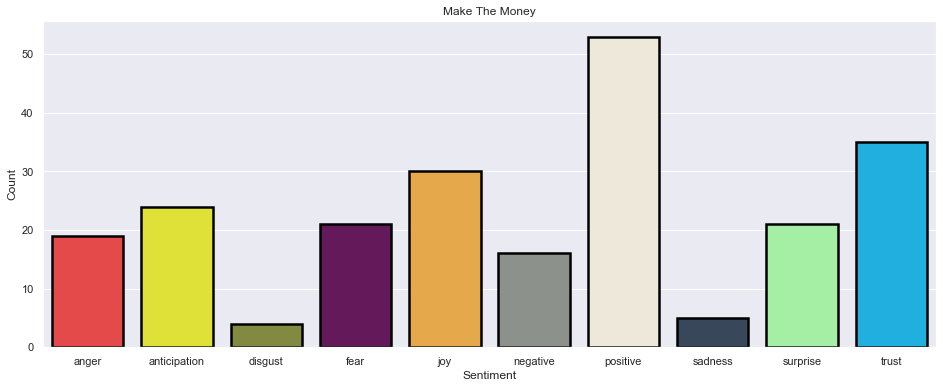

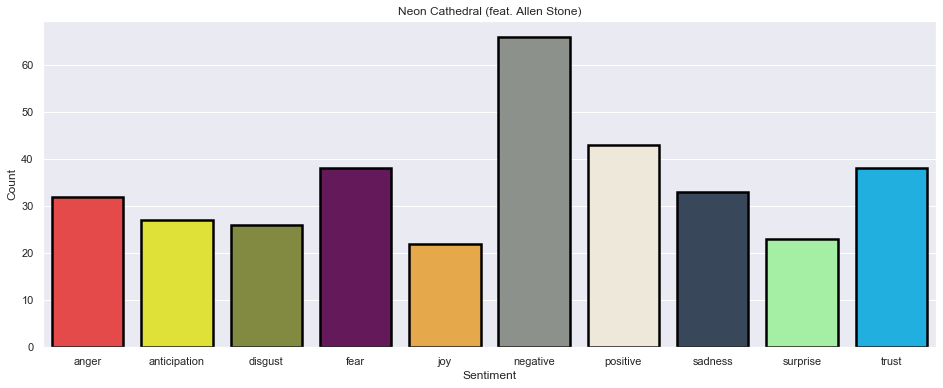

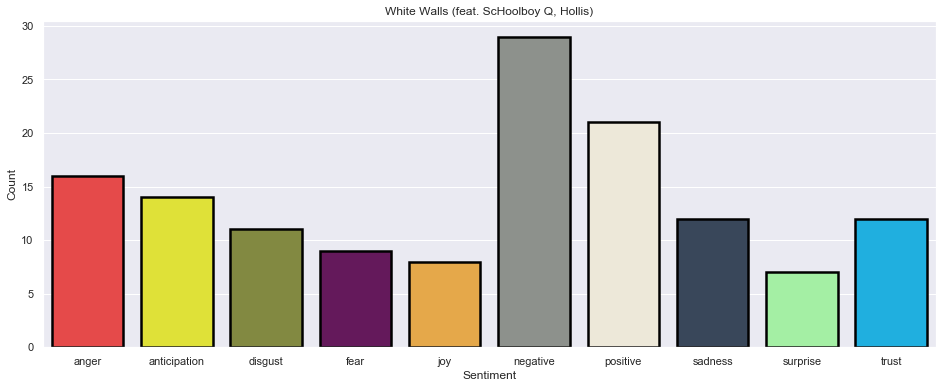

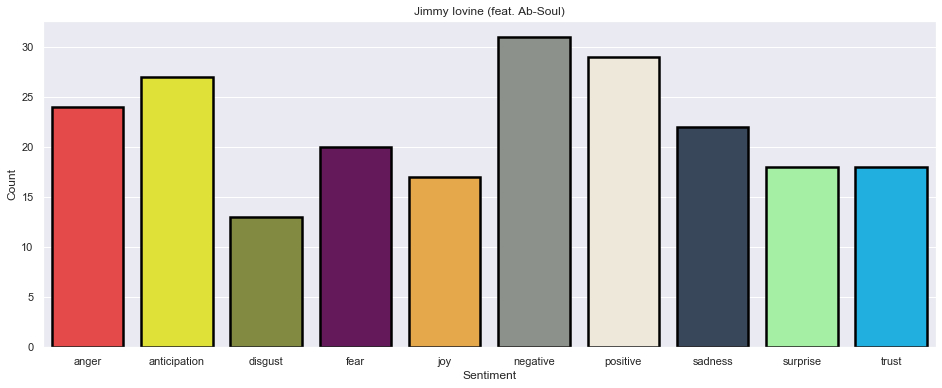

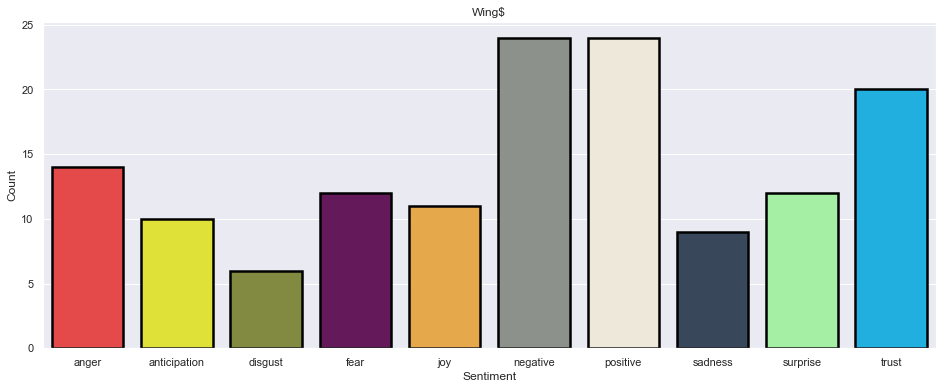

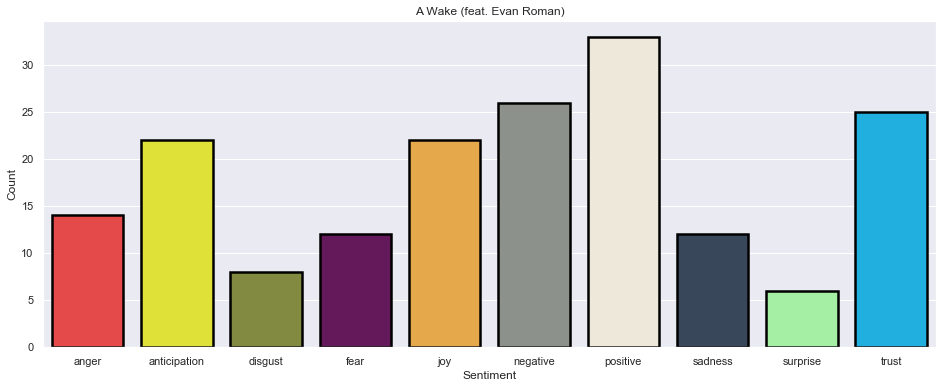

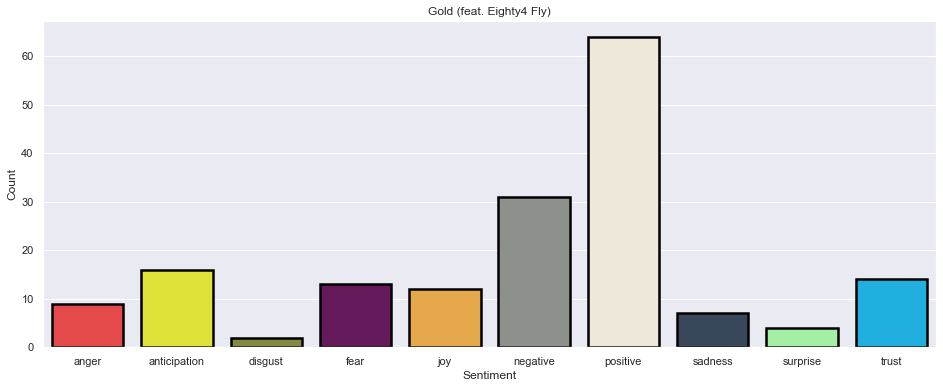

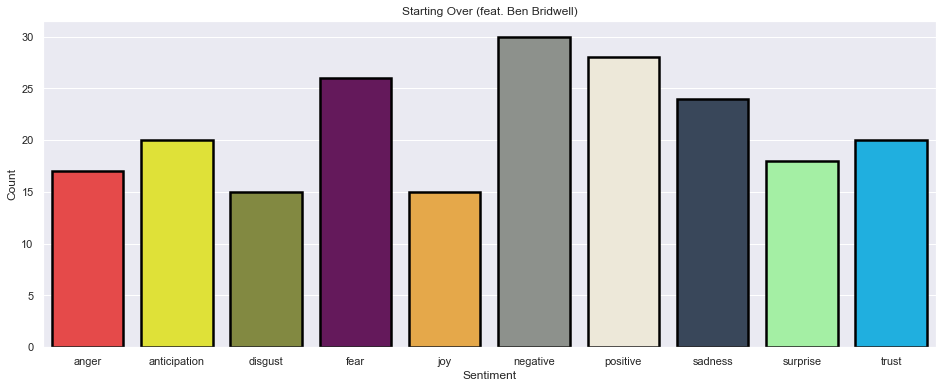

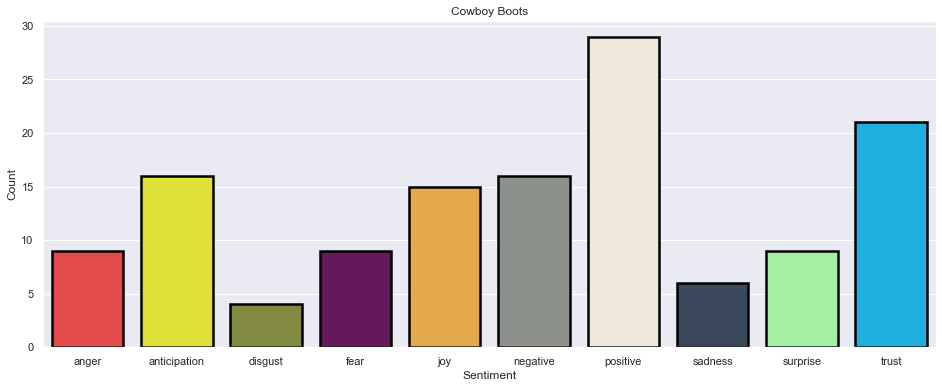

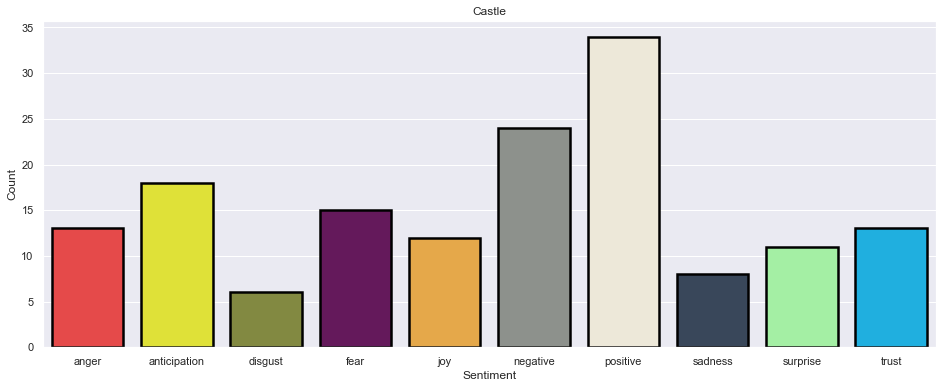

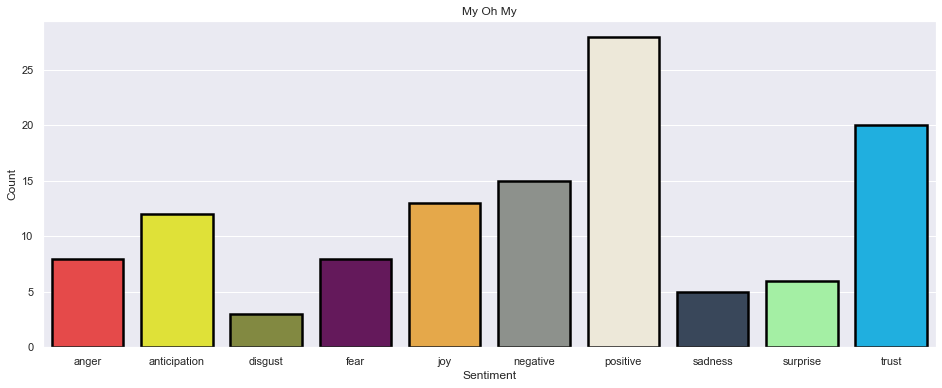

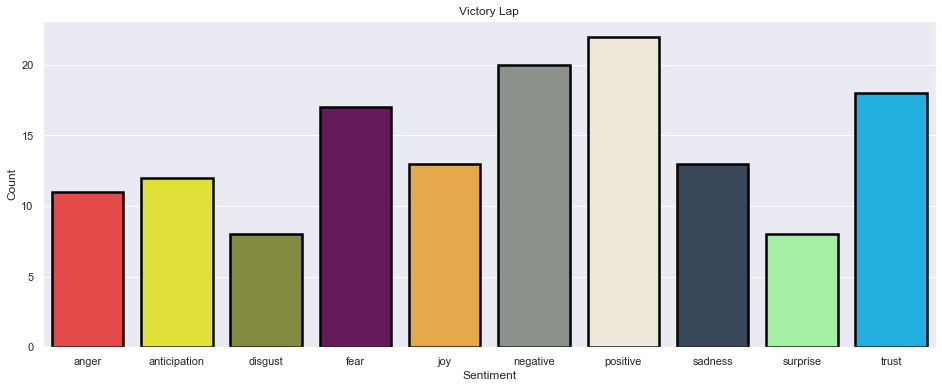

In [25]:
for i in range(17):
    plotSentiment(df['Track'][i])

## Album Sentiment <a name="paragraph7"></a>
[Back to top](#top)

In [26]:
sums = allsong_df.drop(['Track'], axis=1).select_dtypes(pd.np.number).sum().rename('total')
total_df = allsong_df.drop(['Track'], axis=1).append(sums)
total_df = total_df.loc['total']
total_graph = total_df.to_frame().reset_index()
total_graph = total_graph.rename(columns={'index': 'sentiment'})

total_graph

,sentiment,total
0,anger,255.0
1,anticipation,289.0
2,disgust,156.0
3,fear,276.0
4,joy,290.0
5,negative,482.0
6,positive,582.0
7,sadness,221.0
8,surprise,179.0
9,trust,342.0


Text(0.5, 1.0, 'Sentiments for The Heist')

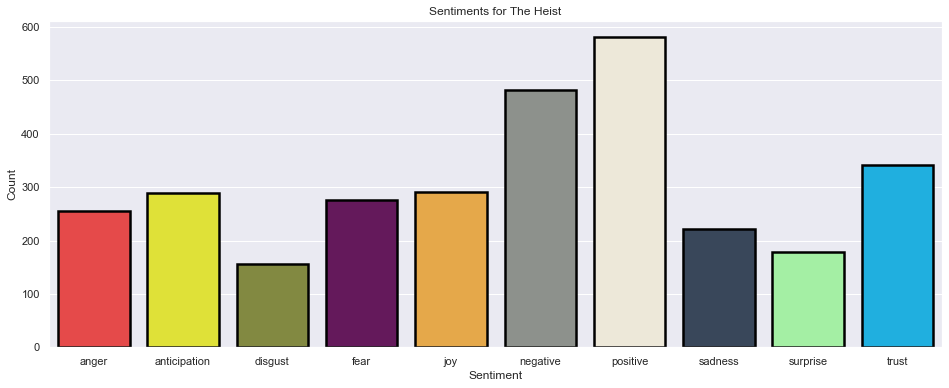

In [27]:
plt.figure(figsize=(16,6))
sns.set(style="darkgrid")
sns.barplot(x = 'sentiment', y='total', 
            data= total_graph, 
            palette=["#ff3030", "#fbfd1c","#8c9535", "#700d64", 
                     "#ffad30", "#8c928b", "#F0EAD6", "#334660", "#98fb98", "#00bfff"],
            linewidth=2.5, edgecolor="0")

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiments for The Heist')

## Conclusion <a name="paragraph8"></a>
[Back to top](#top)

The main reason for choosing The Heist for my analysis was more than because I loved the album; I wanted to showcase the emotional roller coaster from start to finish within the album. Based on the last album sentiment graph, I would say the analysis reflected this pertty well. The emotions other than negative and positive (which are broader than the other specific emotions) are all around the same level of nrc word count. That is, when we add up the sentiment counts of all the individual songs - the happy ones and the sad ones - we get overall a well balanced emotional album with no sentiment count too extraneously high or low. For me, that versatility and diversity really makes this album what it is: a great balance of feel good and introspection. I highly recommend checking out the album to see how well the analysis reflects the song's intent, and also for personal enjoyment.


Thanks for reading!